<a href="https://colab.research.google.com/github/RohmaButt/atl-notebooks/blob/main/Voice_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q tensorflow tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 836.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
# Import necessary libraries
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import soundfile as sf  # For reading audio files

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

*   List item
*   List item



To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
# Define the dataset path
DATASET_PATH = 'data/mini_speech_commands'

# Create a Path object
data_dir = pathlib.Path(DATASET_PATH)

# Download and extract the dataset if it doesn't already exist
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
# List the available commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)


Commands: ['right' 'stop' 'up' 'down' 'left' 'yes' 'go' 'no']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
# Load the dataset
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

# Extract label names
label_names = np.array(train_ds.class_names)
print("\nLabel names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

[link text](https://)This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
# Function to remove the extra channel dimension
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# Apply the function to the datasets
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
# Split the validation set into validation and test sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


In [ ]:
# Inspect the shapes of the data
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)


(64, 16000)
(64,)


*Let*'s plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

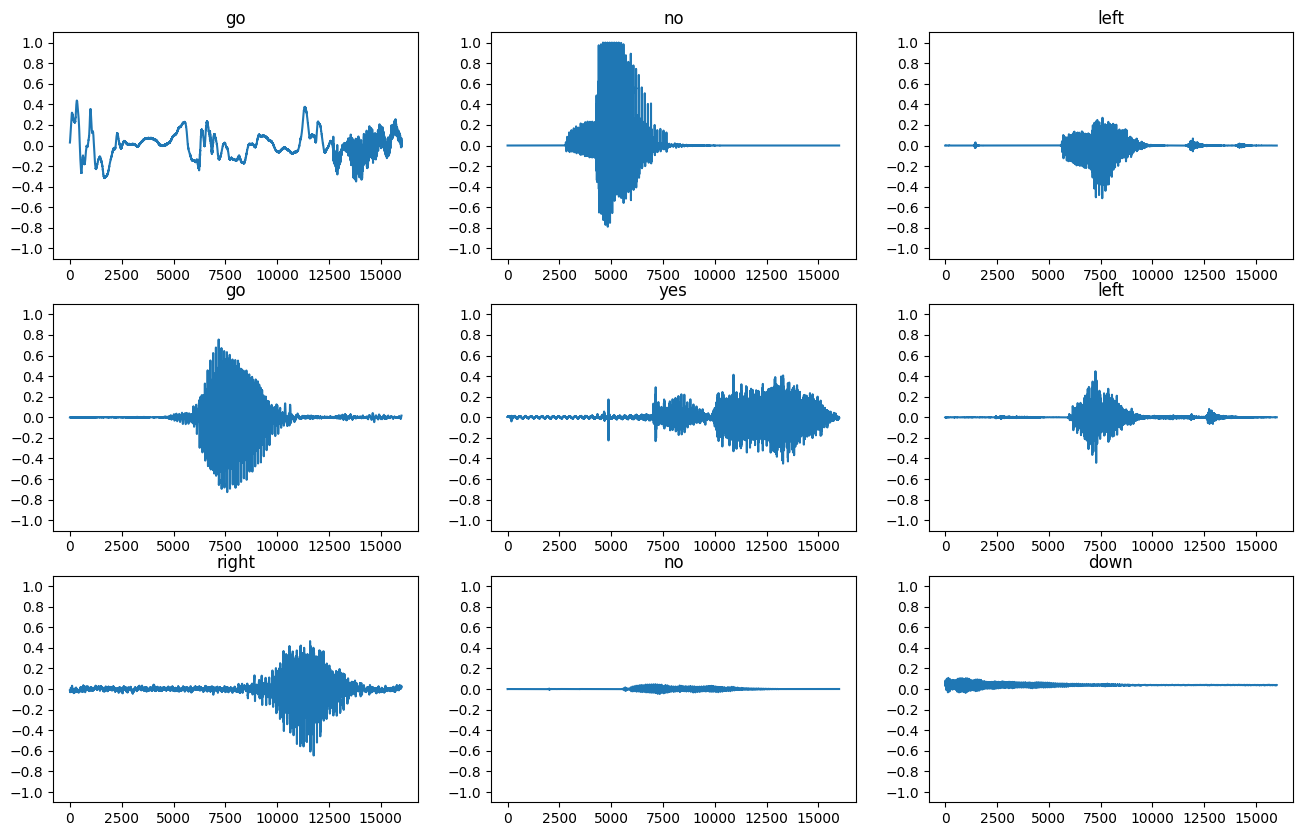

In [ ]:
# Plot a few audio waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()


## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
# Function to plot spectrograms
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert frequencies to log scale
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

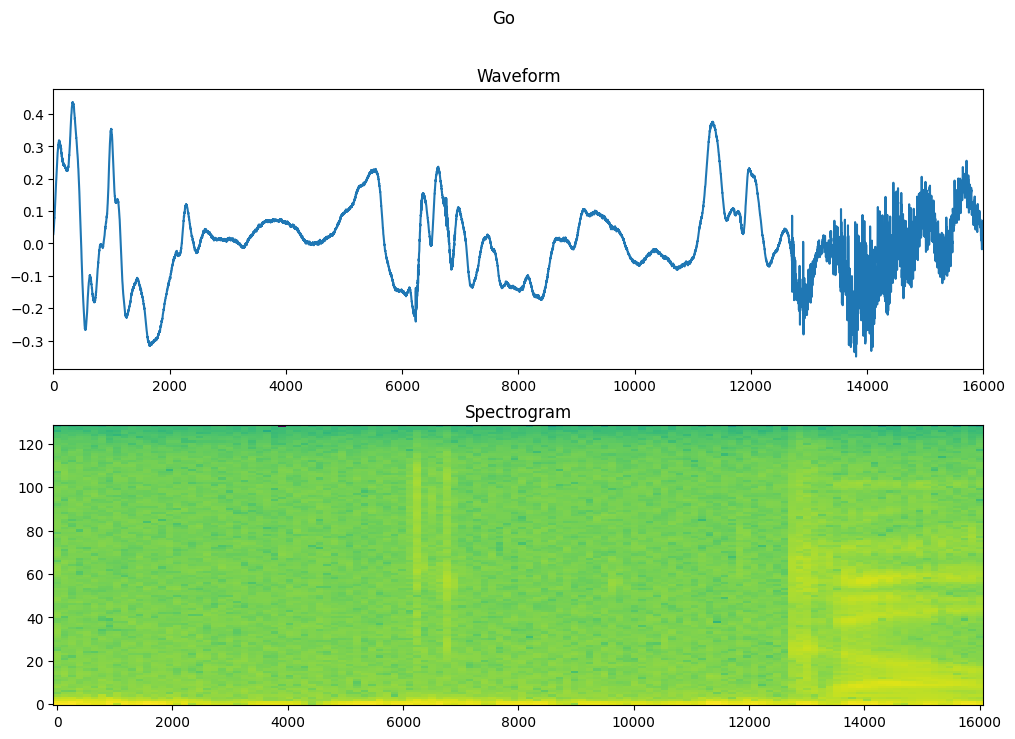

In [ ]:
# Compute spectrogram for the first example
spectrogram = tf.signal.stft(
    example_audio[0], frame_length=255, frame_step=128)
spectrogram = tf.abs(spectrogram)
spectrogram = spectrogram[..., tf.newaxis]

# Plot waveform and spectrogram
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(example_audio[0].shape[0])
axes[0].plot(timescale, example_audio[0].numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label_names[example_labels[0]].title())
plt.show()


Now, create spectrogram datasets from the audio datasets:

In [ ]:
# Function to compute mean and std of spectrograms
def compute_stats(ds):
    mean = 0.0
    var = 0.0
    count = 0
    for spectrogram, _ in ds:
        mean += tf.reduce_sum(spectrogram)
        var += tf.reduce_sum(tf.square(spectrogram))
        count += tf.size(spectrogram).numpy()
    mean /= count
    var = (var / count) - tf.square(mean)
    std = tf.sqrt(var)
    return mean.numpy(), std.numpy()

# Placeholder spectrogram dataset (to compute stats)
# We'll create it from train_ds by mapping the spectrogram generation
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

# Create spectrogram dataset
train_spectrogram_ds_temp = make_spec_ds(train_ds)

# Compute mean and std
mean, std = compute_stats(train_spectrogram_ds_temp)
print(f"Spectrogram Mean: {mean}, Spectrogram Std: {std}")


Spectrogram Mean: 0.12540943920612335, Spectrogram Std: 0.7642194628715515


In [ ]:
# Define spectrogram generation function with normalization
def get_spectrogram_normalized(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    # Normalize spectrogram
    spectrogram = (spectrogram - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero
    return spectrogram

# Function to create spectrogram datasets with normalization
def make_spec_ds_normalized(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram_normalized(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

# Create spectrogram datasets with normalization
train_spectrogram_ds = make_spec_ds_normalized(train_ds)
val_spectrogram_ds = make_spec_ds_normalized(val_ds)
test_spectrogram_ds = make_spec_ds_normalized(test_ds)


Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

<ipython-input-14-460306f44b75>:7: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)


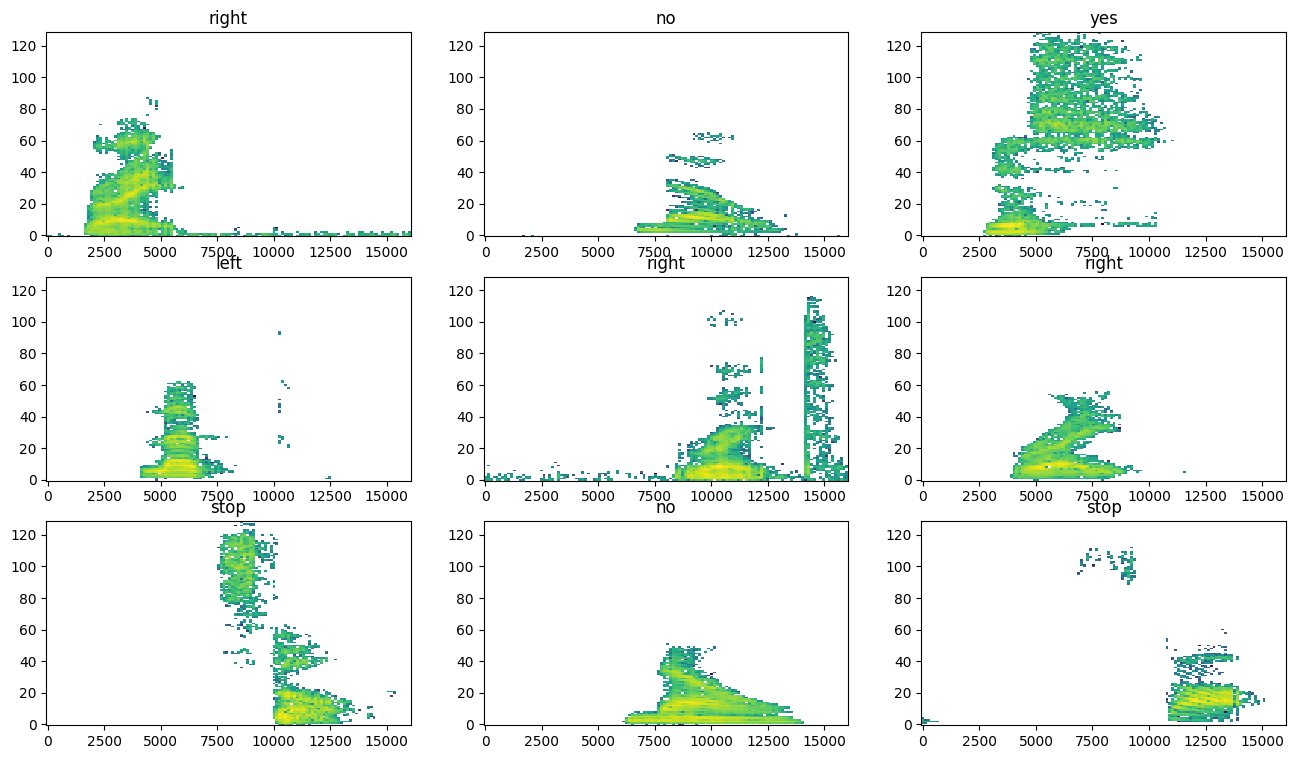

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

\Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
# Cache and prefetch the datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
# Define input shape and number of labels
for spectrogram_batch, label_batch in train_spectrogram_ds.take(1):
    spectrogram = spectrogram_batch[0]
    break

input_shape = spectrogram.shape  # Should be (124, 129, 1)
print('Input shape:', input_shape)
num_labels = len(label_names)

# Build the model without the Normalization layer
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,608 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
# Compile the model with Adam optimizer and Sparse Categorical Crossentropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


Train the model over 10 epochs for demonstration purposes:

In [ ]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 286ms/step - accuracy: 0.2601 - loss: 1.9222 - val_accuracy: 0.5820 - val_loss: 1.2890
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.5421 - loss: 1.3027 - val_accuracy: 0.6927 - val_loss: 0.9556
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.6769 - loss: 0.9372 - val_accuracy: 0.7565 - val_loss: 0.7611
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.7340 - loss: 0.7564 - val_accuracy: 0.8125 - val_loss: 0.6537
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.7807 - loss: 0.6379 - val_accuracy: 0.8190 - val_loss: 0.5986
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.8115 - loss: 0.5676 - val_accuracy: 0.8164 - val_loss: 0.5596
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.8272 - loss: 0.4838 - val_accuracy: 0.8385 - val_loss: 0.5244
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.8367 - loss: 0

Let's plot the training and validation loss curves to check how your model has improved during training:

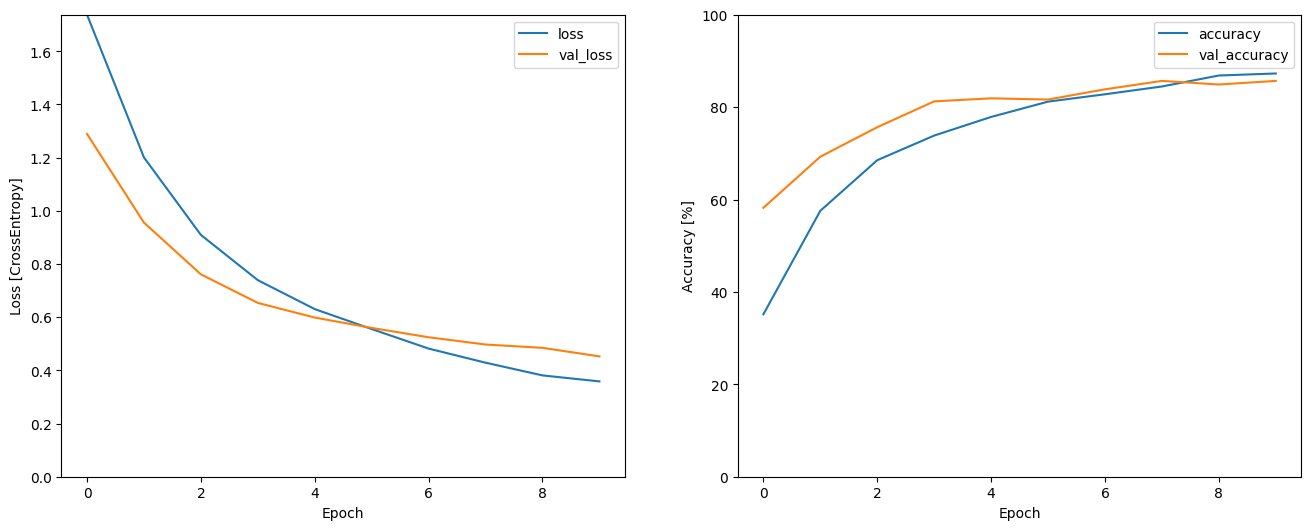

In [ ]:
# Plot training and validation loss and accuracy
metrics = history.history
plt.figure(figsize=(16,6))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], label='loss')
plt.plot(history.epoch, metrics['val_loss'], label='val_loss')
plt.legend()
plt.ylim([0, max(max(metrics['loss']), max(metrics['val_loss']))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='accuracy')
plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='val_accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()


## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_spectrogram_ds, return_dict=True)
print(evaluation)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.8251 - loss: 0.5146
{'accuracy': 0.8365384340286255, 'loss': 0.4999189078807831}


### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


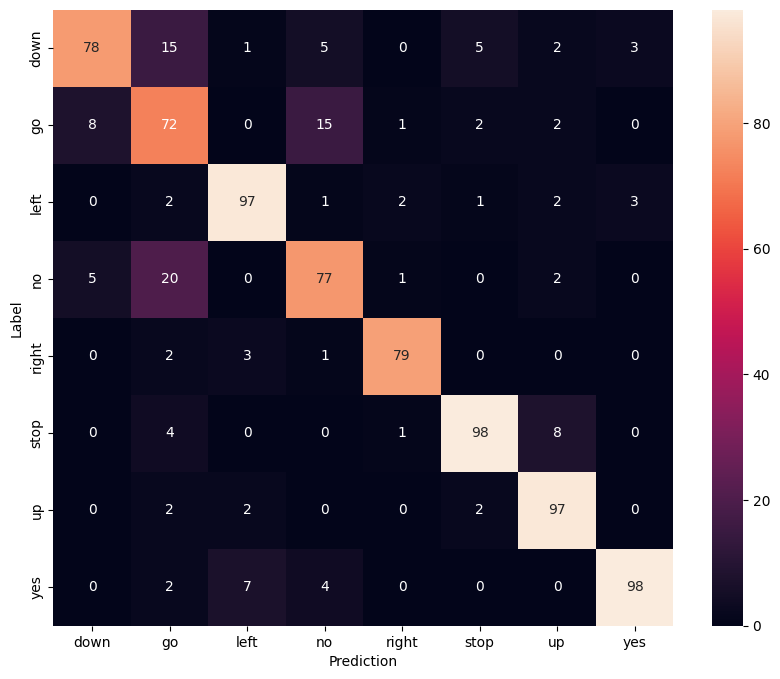

In [ ]:
# Predict on the test set
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

# Compute confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

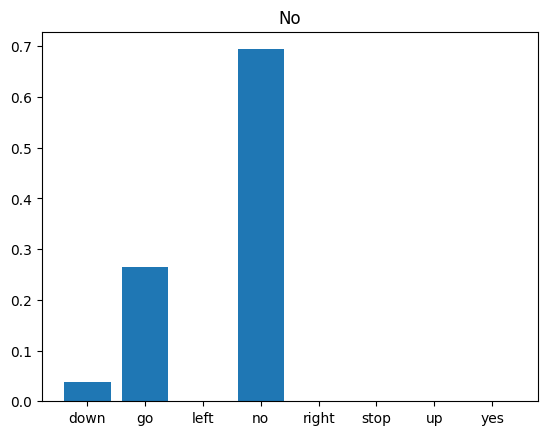

In [ ]:
# Select an audio file to test inference
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
spectrogram = get_spectrogram_normalized(x).numpy()

# Add batch dimension
spectrogram = np.expand_dims(spectrogram, axis=0)

# Perform prediction
prediction = model(spectrogram)

# Define labels
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# Plot prediction probabilities
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

# Play the audio
display.display(display.Audio(waveform, rate=16000))


As the output suggests, your model should have recognized the audio command as "go".

## Export the model with preprocessing

In [ ]:
# Convert the Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# No quantization settings for basic (float) model
tflite_model = converter.convert()

# Save the TFLite model
with open("voice_recognition_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Basic TFLite model conversion successful. Saved as 'voice_recognition_model.tflite'.")


Saved artifact at '/tmp/tmpl2ufibay'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  134546514289312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514287552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514281744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514280512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514282096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514061520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514057472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134546514058176: TensorSpec(shape=(), dtype=tf.resource, name=None)
Basic TFLite model conversion successful. Saved as 'voice_recognition_model.tflite'.


In [ ]:
label_names = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# Save labels to a text file
with open("labels.txt", "w") as f:
    for label in label_names:
        f.write(f"{label}\n")

print("labels.txt generated successfully.")


labels.txt generated successfully.


In [ ]:
!python /content/test_tflite_model.py

python3: can't open file '/content/test_tflite_model.py': [Errno 2] No such file or directory
